In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'BTC'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/Resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-16,223.917007,229.671997,223.917007,228.572998,228.572998,24805400.0
2015-04-17,228.574997,228.906006,221.942001,222.882004,222.882004,20429800.0
2015-04-18,222.852997,224.315994,220.876007,223.356003,223.356003,12939000.0
2015-04-19,223.455994,226.352997,222.373001,222.600006,222.600006,15021500.0
2015-04-20,222.612000,226.350998,221.977005,224.626007,224.626007,18364700.0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-13,61451.22,63422.66,60769.84,62901.45,62901.45,2.788918e+10
2024-05-14,62900.77,63092.13,61123.77,61552.79,61552.79,2.818627e+10
2024-05-15,61553.99,66454.45,61330.41,66267.49,66267.49,3.981517e+10
2024-05-16,66256.11,66712.43,64613.05,65231.58,65231.58,3.157308e+10
2024-05-17,65231.30,67459.46,65119.32,67051.88,67051.88,2.803128e+10


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

67051.88

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999495,0.999140,0.998824,0.998824,0.649250
High,0.999495,1.000000,0.999001,0.999491,0.999491,0.654922
Low,0.999140,0.999001,1.000000,0.999386,0.999386,0.638814
Close,0.998824,0.999491,0.999386,1.000000,1.000000,0.647732
Adj Close,0.998824,0.999491,0.999386,1.000000,1.000000,0.647732
Volume,0.649250,0.654922,0.638814,0.647732,0.647732,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2015-04-16,228.572998,2.480540e+07
2015-04-17,222.882004,2.042980e+07
2015-04-18,223.356003,1.293900e+07
2015-04-19,222.600006,1.502150e+07
2015-04-20,224.626007,1.836470e+07
...,...,...
2024-05-13,62901.450000,2.788918e+10
2024-05-14,61552.790000,2.818627e+10
2024-05-15,66267.490000,3.981517e+10


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2015-06-04,224.324005,14728100.0,231.136499,235.444267,233.35920
2015-06-05,224.951996,18056500.0,229.920099,235.283267,233.28678
2015-06-06,225.619003,11131500.0,228.753699,234.892767,233.34152
2015-06-07,222.880997,13318400.0,227.300998,234.193367,233.33202
2015-06-08,228.488998,23378400.0,226.440298,233.748600,233.44980


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-13,62901.45,2.788918e+10,62359.360,63073.469948,65427.882282
2024-05-14,61552.79,2.818627e+10,62125.492,62933.938729,65259.761832
2024-05-15,66267.49,3.981517e+10,62349.128,63028.648031,65185.354914
2024-05-16,65231.58,3.157308e+10,62556.091,63074.535333,65100.879639
2024-05-17,67051.88,2.803128e+10,63027.797,63267.041667,65027.018176


<Axes: xlabel='Date'>

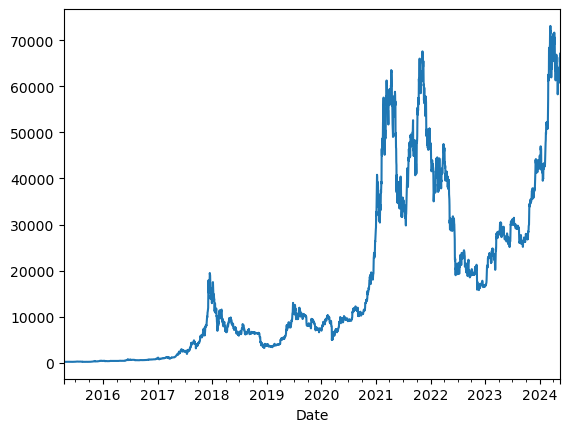

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2015-04-16,228.572998,2.480540e+07
1,2015-04-17,222.882004,2.042980e+07
2,2015-04-18,223.356003,1.293900e+07
3,2015-04-19,222.600006,1.502150e+07
4,2015-04-20,224.626007,1.836470e+07
...,...,...,...
3315,2024-05-13,62901.450000,2.788918e+10
3316,2024-05-14,61552.790000,2.818627e+10
3317,2024-05-15,66267.490000,3.981517e+10
3318,2024-05-16,65231.580000,3.157308e+10


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
3405,2024-08-11
3406,2024-08-12
3407,2024-08-13
3408,2024-08-14
3409,2024-08-15


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3380,2024-07-17,54260.597869,46807.043637,59528.312554,53679.123683,54741.986108,-1444.038195,-1444.038195,-1444.038195,50.369873,50.369873,50.369873,-1494.408068,-1494.408068,-1494.408068,0.0,0.0,0.0,52816.559675
3381,2024-07-18,54313.933699,46275.799423,59609.457835,53709.946474,54805.416378,-1467.612654,-1467.612654,-1467.612654,-12.134821,-12.134821,-12.134821,-1455.477833,-1455.477833,-1455.477833,0.0,0.0,0.0,52846.321045
3382,2024-07-19,54367.269528,46339.111536,59439.264118,53735.933470,54871.800619,-1418.940590,-1418.940590,-1418.940590,-5.075496,-5.075496,-5.075496,-1413.865094,-1413.865094,-1413.865094,0.0,0.0,0.0,52948.328938
3383,2024-07-20,54420.605358,46348.542266,59491.448357,53761.026702,54957.210161,-1404.640798,-1404.640798,-1404.640798,-34.806369,-34.806369,-34.806369,-1369.834429,-1369.834429,-1369.834429,0.0,0.0,0.0,53015.964560
3384,2024-07-21,54473.941187,46244.458350,59704.274458,53793.834873,55047.162523,-1341.833502,-1341.833502,-1341.833502,-18.169553,-18.169553,-18.169553,-1323.663948,-1323.663948,-1323.663948,0.0,0.0,0.0,53132.107686
3385,2024-07-22,54527.277017,46407.709263,59248.786199,53816.565635,55133.219317,-1242.595097,-1242.595097,-1242.595097,33.050062,33.050062,33.050062,-1275.645159,-1275.645159,-1275.645159,0.0,0.0,0.0,53284.681920
3386,2024-07-23,54580.612846,46810.832830,60085.092238,53830.540090,55207.145939,-1239.316967,-1239.316967,-1239.316967,-13.233697,-13.233697,-13.233697,-1226.083270,-1226.083270,-1226.083270,0.0,0.0,0.0,53341.295879
3387,2024-07-24,54633.948676,46422.475508,59832.140579,53865.153135,55299.576446,-1124.927927,-1124.927927,-1124.927927,50.369873,50.369873,50.369873,-1175.297801,-1175.297801,-1175.297801,0.0,0.0,0.0,53509.020748
3388,2024-07-25,54687.284505,46820.754369,59992.640311,53887.678836,55372.344319,-1135.758153,-1135.758153,-1135.758153,-12.134821,-12.134821,-12.134821,-1123.623332,-1123.623332,-1123.623332,0.0,0.0,0.0,53551.526353
3389,2024-07-26,54740.620335,46512.608059,60103.567798,53920.405419,55438.100135,-1076.485742,-1076.485742,-1076.485742,-5.075496,-5.075496,-5.075496,-1071.410246,-1071.410246,-1071.410246,0.0,0.0,0.0,53664.134593


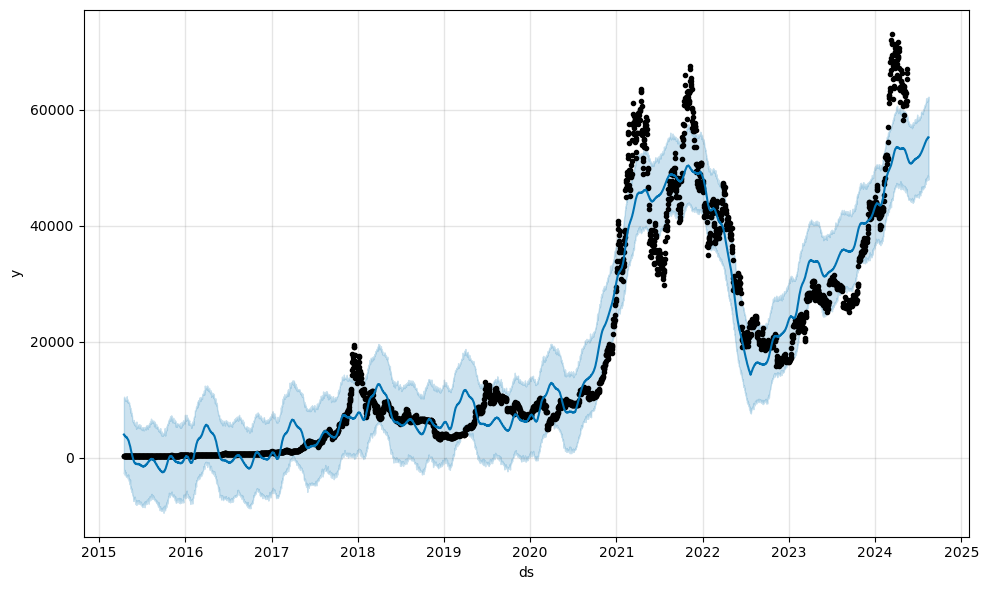

In [20]:
# Plot the Prophet predictions for the data
fig1 = crypto_model.plot(crypto_forecast)

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-18,51718.694340,45211.207917,58700.955795
2024-05-19,51606.441596,45124.237061,58022.091452
2024-05-20,51533.709679,45001.448246,58092.408739
2024-05-21,51369.829911,44656.368806,57826.999573
2024-05-22,51323.482230,44491.589067,57586.979511
...,...,...,...
2024-08-11,55079.832616,47950.692617,61863.520121
2024-08-12,55183.529042,48759.129348,62138.758562
2024-08-13,55183.621792,48332.676955,61569.059648


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

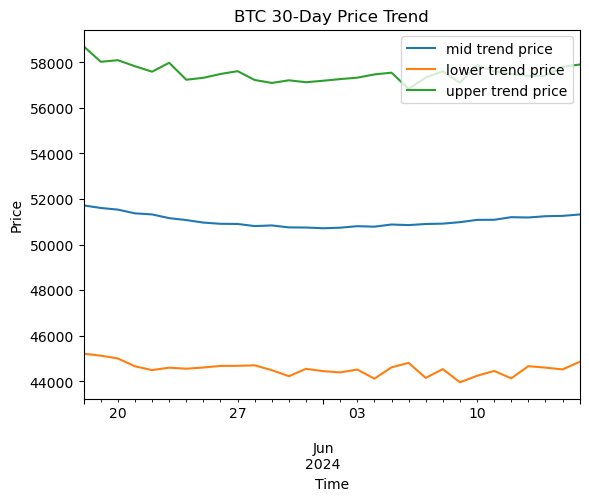

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

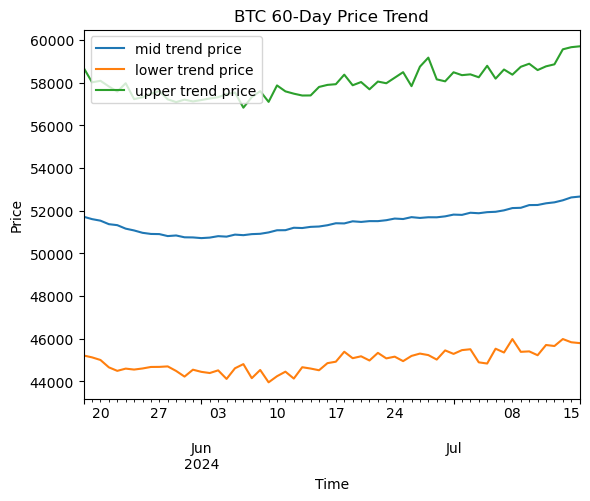

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

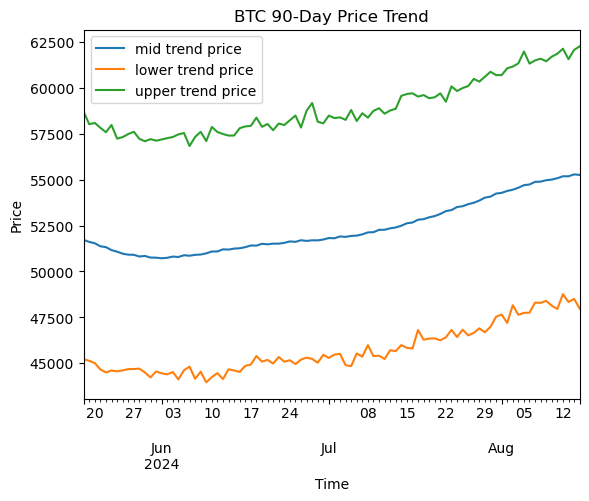

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

67051.88

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

51718.69434045415

In [29]:
# Retrieve mid trend price in 30 days
mid_trend_price_in_30 = crypto_forecast['mid trend price'].iloc[-60]
mid_trend_price_in_30

51412.772057572874

In [30]:
# Retrieve mid trend price in 60 days
mid_trend_price_in_60 = crypto_forecast['mid trend price'].iloc[-30]
mid_trend_price_in_60

52816.55967476774

In [31]:
# Retrieve mid trend price in 90 days
mid_trend_price_in_90 = crypto_forecast['mid trend price'].iloc[-1]
mid_trend_price_in_90

55258.974237196955

In [32]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30.round(3)

-0.233

In [33]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60.round(3)

-0.212

In [34]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90.round(3)

-0.176

In [35]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

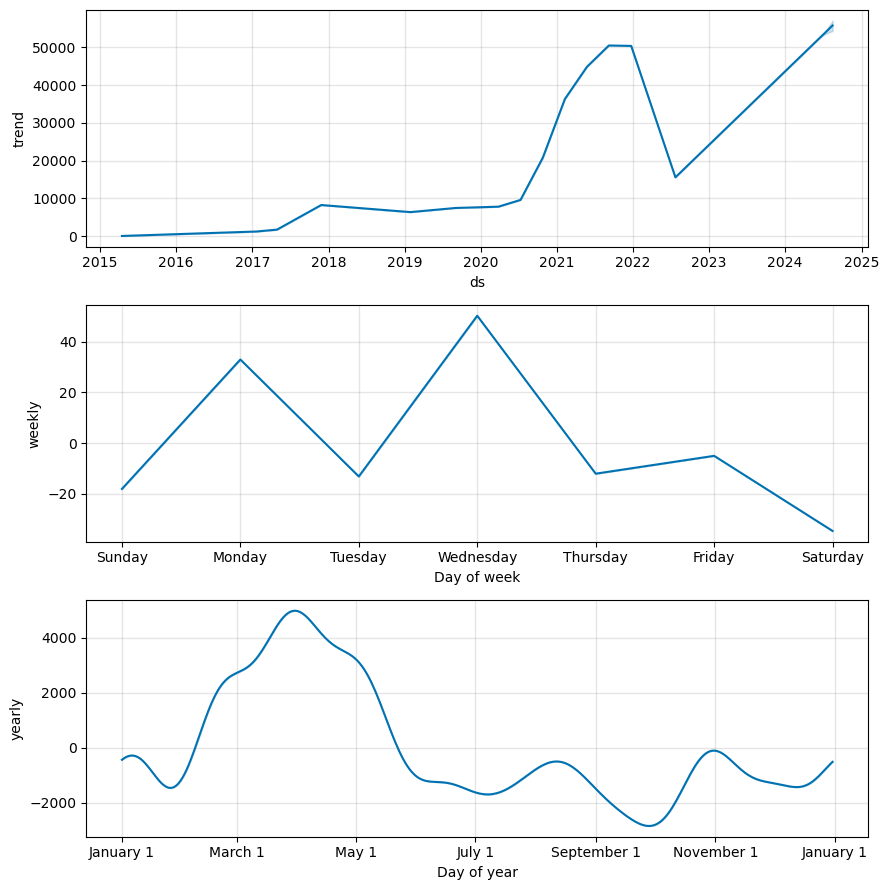

In [36]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig2 = crypto_model.plot_components(crypto_forecast)

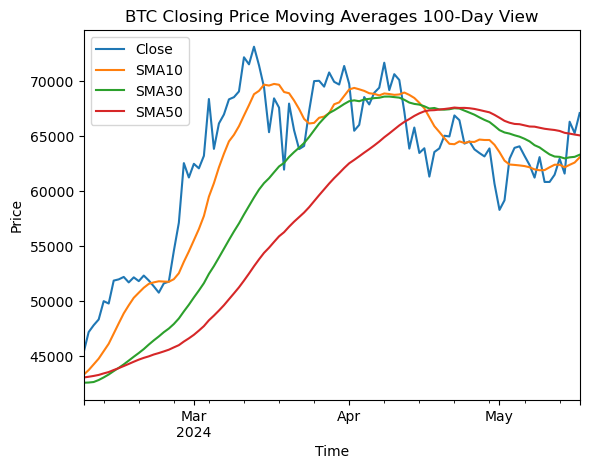

In [37]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

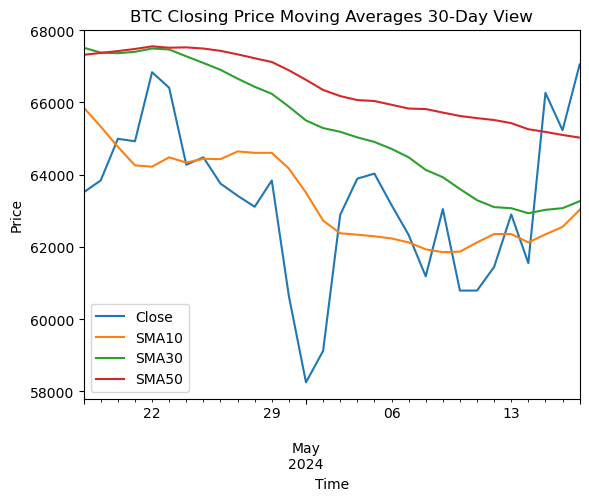

In [38]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.show()

In [39]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-19
File created :  2024-05-19.csv


In [40]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [41]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.481067,-0.006935356560101691,-0.07859463805561773,0.23472349758660838
BNB,580.305542,-0.34535988531321604,-0.3403273855834782,-0.29106901029282883
BONK,2.8e-05,0.1292127878224536,0.2630430622648412,0.38814028120395916
BTC,67051.88,-0.23323891802030206,-0.21230307524907965,-0.17587733204204037

